# Importing Required packages

In [ ]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

#1.Creating Dataset

In [ ]:
np.random.seed(88)
torch.manual_seed(88)

#create_dataset function takes dataset_size and list named lenghts which contains all possible lengths which one sequence can have.
#create_dataset function will return X which contains 2D sequences of different-different lengths and Y contains corresponding label (As mentioned in assignment question)
def create_dataset(dataset_size,lenghts):
  X = []
  Y = torch.zeros(dataset_size,dtype=torch.float64)
  
  for i in tqdm(range(dataset_size)):
    #Sequence generation
    seq_size = np.random.choice(lenghts)
    X_values = np.random.uniform(low=0.0, high=1.0, size=seq_size)
    X_binary = np.zeros(seq_size)
  
    one_positions = np.random.choice(seq_size, size=2, replace=False)
    X_binary[one_positions[0]] =1
    X_binary[one_positions[1]] =1
    #label generation
    Y[i] = X_values[one_positions[0]] + X_values[one_positions[1]]
    
    X_values= X_values.reshape(seq_size,1)
    X_binary= X_binary.reshape(seq_size,1)
    X_temp = torch.from_numpy((np.append(X_values, X_binary, axis=1)))    
    X.append(X_temp)

  return X,Y


In [ ]:
torch.manual_seed(88)
np.random.seed(88)

dataset_size=5000
min_seq_lenght = 2
max_seq_lenght = 10
seq_lenghts = np.arange(min_seq_lenght,max_seq_lenght,dtype=int)

X,y = create_dataset(dataset_size=dataset_size,lenghts=seq_lenghts)

100%|██████████| 5000/5000 [00:01<00:00, 3520.62it/s]


In [ ]:
print("Total generated data points:",len(X))
print("Total generated labels points:",len(y))

Total generated data points: 5000
Total generated labels points: 5000


In [ ]:
print("-----One of the generated datapoint-----:")
print(X[5])

print("\n\n---------corresponding label------------:")
print(y[5])

print("\n\n----We can verify that label is indeed sum of the values mentioned by 1 in sequence----------:")
print("0.6438+0.2511 :",0.6438+0.2511)

-----One of the generated datapoint-----:
tensor([[0.1152, 0.0000],
        [0.6438, 1.0000],
        [0.5893, 0.0000],
        [0.1760, 0.0000],
        [0.2511, 1.0000],
        [0.1835, 0.0000]], dtype=torch.float64)


---------corresponding label------------:
tensor(0.8949, dtype=torch.float64)


----We can verify that label is indeed sum of the values mentioned by 1 in sequence----------:
0.6438+0.2511 : 0.8949


### 1.1 Creating train test split

In [ ]:
torch.manual_seed(88)
np.random.seed(88)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
print("Size of training dataset:",len(X_train))
print("Size of test dataset:",len(y_test))

Size of training dataset: 3350
Size of test dataset: 1650


#**2.Elmon RNN**

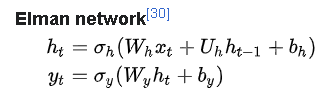

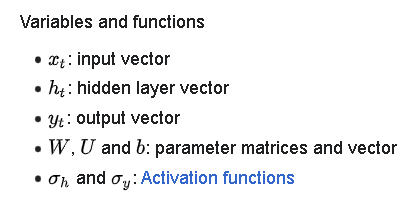

### 2.1 Elmon RNN class

In [ ]:
torch.manual_seed(88)

#Class for Elmon RNN
class Elmon_RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(Elmon_RNN,self).__init__()
    self.hidden_size = hidden_size

    self.x2h = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.h2y = nn.Linear(hidden_size, output_size,bias=True,dtype=torch.float64) 
    self.tanh = nn.Tanh()
  
  #forward pass of the elmon RNN
  def forward(self, input_tensor, hidden):
    combined = torch.cat((input_tensor, hidden), 1) 
    hidden = self.tanh(self.x2h(combined))
    output = self.h2y(hidden)
    return output, hidden
  
  #Initialization of hidden state
  def initHidden(self):
    return torch.zeros(1,self.hidden_size,dtype=torch.float64)

### 2.2 Defining model(Object of class Elmon RNN), loss functions, model input, output and hidden state or layer size



In [ ]:
torch.manual_seed(88)

input_size=2
hidden_size=4
output_size=1
#Mean Square error as Loss function
criterion = nn.MSELoss()
learning_rate = 0.01

elmon = Elmon_RNN(input_size=input_size,hidden_size=hidden_size,output_size=output_size)
optimizer = torch.optim.Adam(elmon.parameters(),lr=learning_rate)

In [ ]:
named_layers = dict(elmon.named_modules())
named_layers

{'': Elmon_RNN(
   (x2h): Linear(in_features=6, out_features=4, bias=True)
   (h2y): Linear(in_features=4, out_features=1, bias=True)
   (tanh): Tanh()
 ),
 'x2h': Linear(in_features=6, out_features=4, bias=True),
 'h2y': Linear(in_features=4, out_features=1, bias=True),
 'tanh': Tanh()}

###2.3 Training loop

#####2.3.1 Training loop for 1 sequence

In [ ]:
torch.manual_seed(88)

#This will take one sequence as input, which is of type tensor and one single ground truth value.
#Forward pass will take place for each element of sequence
#i.e for each time stamp and each time stamp receive hidden state calculated from previous time stamp  
def training_one_seq(input_seq,ground_truth):
  hidden = elmon.initHidden()
  ground_truth_temp = torch.reshape(ground_truth,(1,1))
  
  #forward
  #for each time stamp
  for i in range(input_seq.size()[0]):
    temp = torch.reshape(input_seq[i],(1,2))
    output,hidden = elmon(temp,hidden)
  
  #Loss calculation and backpropagation
  loss = criterion(output,ground_truth)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output,loss

#####2.3.2 Main Training loop for 20 epochs  (This will call training_one_seq function for each squence of epoch)

In [ ]:
torch.manual_seed(88)
epoch = 20
elmon_loss = []
total_loss = 0

#This code will reset the parameters values so that we donot have to run the code from starting for each experiment
for layer in elmon.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

#Main training loop, for each epoch of training training_one_seq function will be called which is written and explained in above cell
for i in tqdm(range(epoch)):
  total_loss = 0
  for j in range(len(X_train)):
    _,temp_loss = training_one_seq(X_train[j],y_train[j])
    total_loss = total_loss + temp_loss.item()
  elmon_loss.append(total_loss/len(X_train))

100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


#####2.3.3 Loss value for each epoch

In [ ]:
torch.manual_seed(88)

elmon_loss = np.array(elmon_loss)
for i in range(len(elmon_loss)):
  print("Loss for",i+1,"epoch:",elmon_loss[i])

Loss for 1 epoch: 0.12794843461075447
Loss for 2 epoch: 0.0943453139246552
Loss for 3 epoch: 0.04077882786325448
Loss for 4 epoch: 0.018111465514749982
Loss for 5 epoch: 0.01683235422710563
Loss for 6 epoch: 0.015605141452929558
Loss for 7 epoch: 0.014179731183720162
Loss for 8 epoch: 0.013077314501633977
Loss for 9 epoch: 0.012671966914215814
Loss for 10 epoch: 0.012584025408370465
Loss for 11 epoch: 0.012425813126623038
Loss for 12 epoch: 0.012545681040412964
Loss for 13 epoch: 0.012462821946287367
Loss for 14 epoch: 0.012443263955365791
Loss for 15 epoch: 0.012614258425696473
Loss for 16 epoch: 0.012537962650115414
Loss for 17 epoch: 0.012968355631349052
Loss for 18 epoch: 0.012485108260456908
Loss for 19 epoch: 0.012787676971641914
Loss for 20 epoch: 0.012496362796492766


###2.4 Ploting Epoch vs traning loss plot for Elmon RNN

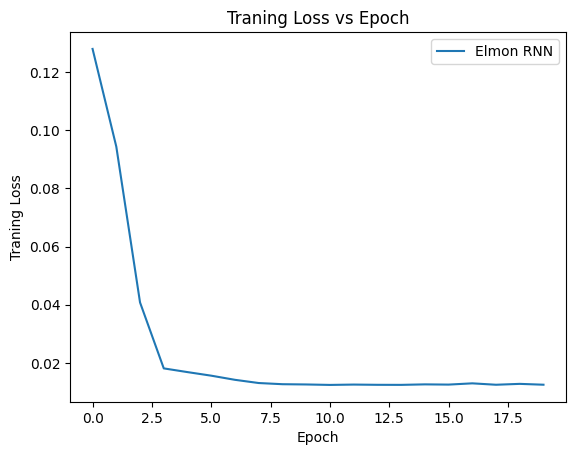

In [ ]:
plt.plot(np.arange(epoch),elmon_loss,label="Elmon RNN")
plt.xlabel("Epoch")
plt.ylabel("Traning Loss")
plt.title("Traning Loss vs Epoch")
plt.legend()
plt.show()

#**3. LSTM**

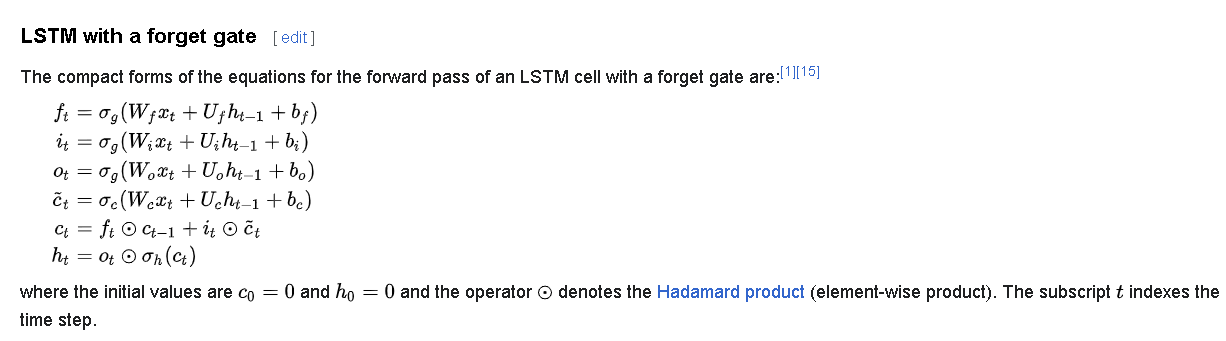

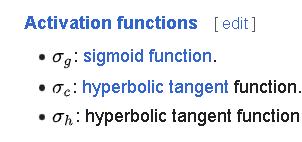

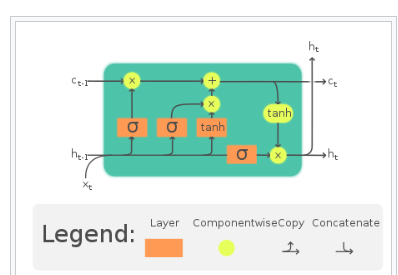

### 3.1 LSTM class

In [ ]:
torch.manual_seed(88)

#Class for LSTM
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(LSTM,self).__init__()
    self.hidden_size = hidden_size

    self.x2f = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.x2i = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.x2cplus = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.x2o = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.h2y = nn.Linear(hidden_size, output_size,bias=True,dtype=torch.float64) 
    self.tanh = nn.Tanh()
    self.sigmoid =nn.Sigmoid()

  #forward pass of the LSTM
  def forward(self, input_tensor, hidden,cell):
    combined = torch.cat((input_tensor, hidden), 1) 
    ft = self.sigmoid(self.x2f(combined))
    ctdess = ft * cell
    it = self.sigmoid(self.x2i(combined))
    ctplus = self.tanh(self.x2cplus(combined))
    cell = ctdess + (it*ctplus)
    ot = self.sigmoid(self.x2o(combined))
    hidden = ot * self.tanh(cell)
    output = self.h2y(hidden)
    return output, hidden,cell
  
  #Initialization of hidden state
  #Same function will be used for the Initialization of cell state since hidden and cell state has same size
  def initHidden(self):
    return torch.zeros(1,self.hidden_size,dtype=torch.float64)


### 3.2 Defining model(Object of class LSTM), loss functions, model input, output and cell state

In [ ]:
torch.manual_seed(88)

#Mean Square error as Loss function
criterion = nn.MSELoss()
learning_rate = 0.01

input_size=2
cell_state_size=16
output_size=1

lstm = LSTM(input_size=input_size,hidden_size=cell_state_size,output_size=output_size)
optimizer = torch.optim.Adam(lstm.parameters(),lr=learning_rate)

In [ ]:
torch.manual_seed(88)
named_layers = dict(lstm.named_modules())
named_layers

{'': LSTM(
   (x2f): Linear(in_features=18, out_features=16, bias=True)
   (x2i): Linear(in_features=18, out_features=16, bias=True)
   (x2cplus): Linear(in_features=18, out_features=16, bias=True)
   (x2o): Linear(in_features=18, out_features=16, bias=True)
   (h2y): Linear(in_features=16, out_features=1, bias=True)
   (tanh): Tanh()
   (sigmoid): Sigmoid()
 ),
 'x2f': Linear(in_features=18, out_features=16, bias=True),
 'x2i': Linear(in_features=18, out_features=16, bias=True),
 'x2cplus': Linear(in_features=18, out_features=16, bias=True),
 'x2o': Linear(in_features=18, out_features=16, bias=True),
 'h2y': Linear(in_features=16, out_features=1, bias=True),
 'tanh': Tanh(),
 'sigmoid': Sigmoid()}

### 3.3 Training loop

##### 3.3.1 Training loop for 1 sequence

In [ ]:
torch.manual_seed(88)

#This will take one sequence as input, which is of type tensor and one single ground truth value.
#Forward pass will take place for each element of sequencei.e for each time stamp and each time stamp receives hidden state,cell state calculated from previous time stamp
def training_one_seq(input_seq,ground_truth):
  hidden = lstm.initHidden()
  cell = lstm.initHidden()
  ground_truth_temp = torch.reshape(ground_truth,(1,1))
  
  #forward
  #for each time stamp
  for i in range(input_seq.size()[0]):

    temp = torch.reshape(input_seq[i],(1,2))
    output,hidden,cell = lstm(temp,hidden,cell)
  
  #Loss calculation and backpropagation
  loss = criterion(output,ground_truth)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output,loss

##### 3.3.2 Main Training loop for 20 epochs (This will call training_one_seq function for each squence of epoch)

In [ ]:
torch.manual_seed(88)
epoch = 20
lstm_loss = []
total_loss = 0

#This code will reset the parameters values so that we donot have to run the code from starting for each experiment
for layer in lstm.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

#Main training loop, for each epoch of training training_one_seq function will be called which is written and explained in above cell
for i in tqdm(range(epoch)):
  total_loss = 0
  for j in range(len(X_train)):
    _,temp_loss = training_one_seq(X_train[j],y_train[j])
    total_loss = total_loss + temp_loss.item()
  lstm_loss.append(total_loss/len(X_train))



100%|██████████| 20/20 [03:50<00:00, 11.54s/it]


##### 3.3.3 Loss value for each epoch

In [ ]:
lstm_loss = np.array(lstm_loss)
for i in range(len(lstm_loss)):
  print("Loss for",i+1,"epoch:",lstm_loss[i])

Loss for 1 epoch: 0.04128673217651537
Loss for 2 epoch: 0.0023674159475864324
Loss for 3 epoch: 0.0014165469632625065
Loss for 4 epoch: 0.0009679993926367125
Loss for 5 epoch: 0.0007091015267111483
Loss for 6 epoch: 0.0005878333008551094
Loss for 7 epoch: 0.0005016985096016969
Loss for 8 epoch: 0.00038774727894067543
Loss for 9 epoch: 0.00033000202812625656
Loss for 10 epoch: 0.0002942641779038216
Loss for 11 epoch: 0.00026313095573383385
Loss for 12 epoch: 0.0002351883791662134
Loss for 13 epoch: 0.00019892821301915328
Loss for 14 epoch: 0.0001874839664832956
Loss for 15 epoch: 0.00017478200035668016
Loss for 16 epoch: 0.0001698063972642213
Loss for 17 epoch: 0.00016085098526164886
Loss for 18 epoch: 0.0001553178676766555
Loss for 19 epoch: 0.00014888042746649162
Loss for 20 epoch: 0.00014284440115082368


### 3.4 Ploting Epoch vs traning loss plot for LSTM

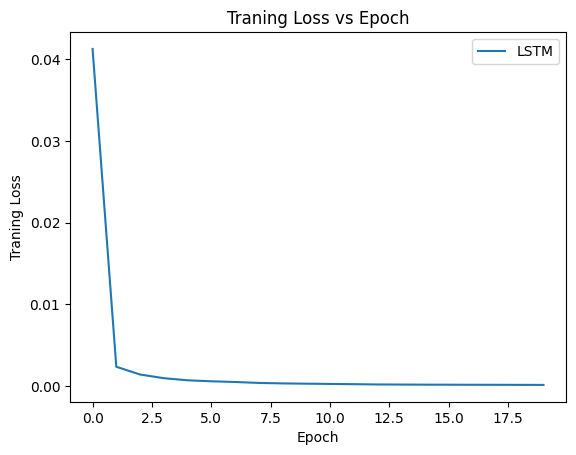

In [ ]:
plt.plot(np.arange(epoch),lstm_loss,label="LSTM")
plt.xlabel("Epoch")
plt.ylabel("Traning Loss")
plt.title("Traning Loss vs Epoch")
plt.legend()
plt.show()

#**4. GRU (Gated recurrent unit)**

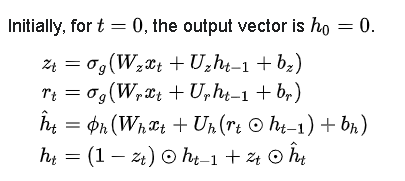

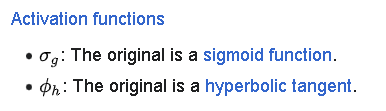

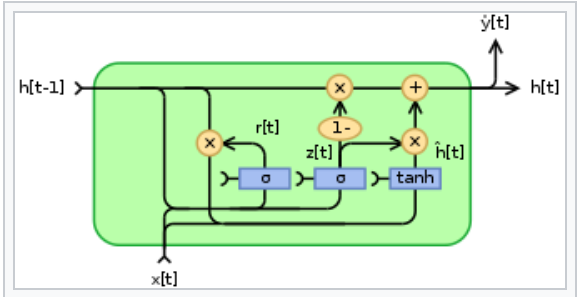

### 4.1 GRU class

In [ ]:
torch.manual_seed(88)

#Class for GRU
class GRU(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(GRU,self).__init__()
    self.hidden_size = hidden_size

    self.x2z = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.x2r = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.x2hdess = nn.Linear(input_size + hidden_size, hidden_size,bias=True,dtype=torch.float64)
    self.h2y = nn.Linear(hidden_size, output_size,bias=True,dtype=torch.float64) 
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()
  
  #forward pass of the GRU
  def forward(self, input_tensor, hidden):
    combined = torch.cat((input_tensor, hidden), 1) 
    zt = self.sigmoid(self.x2z(combined))
    rt = self.sigmoid(self.x2r(combined))
    temp = rt * hidden
    temp_combined = torch.cat((input_tensor, temp), 1)
    htdess = self.tanh(self.x2hdess(temp_combined))
    hidden = zt * hidden + (1-zt) * htdess
    output = self.h2y(hidden)
    return output, hidden
  
  #Initialization of hidden state
  def initHidden(self):
    return torch.zeros(1,self.hidden_size,dtype=torch.float64)


### 4.2 Defining model(Object of class GRU), loss functions, model input,output and hidden state

In [ ]:
torch.manual_seed(88)

#Mean Square error as Loss function
criterion = nn.MSELoss()
learning_rate = 0.01
input_size=2
hidden_size=16
output_size=1

gru = GRU(input_size=input_size,hidden_size=hidden_size,output_size=output_size)
optimizer = torch.optim.Adam(gru.parameters(),lr=learning_rate)

In [ ]:
torch.manual_seed(88)
named_layers = dict(gru.named_modules())
named_layers

{'': GRU(
   (x2z): Linear(in_features=18, out_features=16, bias=True)
   (x2r): Linear(in_features=18, out_features=16, bias=True)
   (x2hdess): Linear(in_features=18, out_features=16, bias=True)
   (h2y): Linear(in_features=16, out_features=1, bias=True)
   (tanh): Tanh()
   (sigmoid): Sigmoid()
 ),
 'x2z': Linear(in_features=18, out_features=16, bias=True),
 'x2r': Linear(in_features=18, out_features=16, bias=True),
 'x2hdess': Linear(in_features=18, out_features=16, bias=True),
 'h2y': Linear(in_features=16, out_features=1, bias=True),
 'tanh': Tanh(),
 'sigmoid': Sigmoid()}

### 4.3 Training loop

##### 4.3.1 Training loop for 1 sequence

In [ ]:
torch.manual_seed(88)

#This will take one sequence as input, which is of type tensor and one single ground truth value.
#Forward pass will take place for each element of sequence i.e for each time stamp and each time stamp receives hidden statecalculated from previous time stamp
def training_one_seq(input_seq,ground_truth):
  hidden = gru.initHidden()
  ground_truth_temp = torch.reshape(ground_truth,(1,1))
  
  #forward
  #for each time stamp
  for i in range(input_seq.size()[0]):

    temp = torch.reshape(input_seq[i],(1,2))
    output,hidden = gru(temp,hidden)
  
  #Loss calculation and backpropagation
  loss = criterion(output,ground_truth)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output,loss

##### 4.3.2 Main Training loop for 20 epochs (This will call training_one_seq function for each squence of epoch)

In [ ]:
torch.manual_seed(88)
epoch = 20
gru_loss = []
total_loss = 0

#This code will reset the parameters values so that we donot have to run the code from starting for each experiment
for layer in gru.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

#Main training loop, for each epoch of training training_one_seq function will be called which is written and explained in above cell
for i in tqdm(range(epoch)):
  total_loss = 0
  for j in range(len(X_train)):
    _,temp_loss = training_one_seq(X_train[j],y_train[j])
    total_loss = total_loss + temp_loss.item()
  gru_loss.append(total_loss/len(X_train))



100%|██████████| 20/20 [03:28<00:00, 10.41s/it]


##### 4.3.3 Loss value for each epoch

In [ ]:
gru_loss = np.array(gru_loss)
for i in range(len(gru_loss)):
  print("Loss for",i+1,"epoch:",gru_loss[i])

Loss for 1 epoch: 0.01724156987575996
Loss for 2 epoch: 0.0015579156648779366
Loss for 3 epoch: 0.0010976167037651558
Loss for 4 epoch: 0.0008426494761241374
Loss for 5 epoch: 0.0006375824614096156
Loss for 6 epoch: 0.0005941775416445343
Loss for 7 epoch: 0.0005050392052614191
Loss for 8 epoch: 0.0004717820942002754
Loss for 9 epoch: 0.00039121819840696364
Loss for 10 epoch: 0.0003421315316159167
Loss for 11 epoch: 0.0003226941672769143
Loss for 12 epoch: 0.0003193916059618754
Loss for 13 epoch: 0.0003117145707849452
Loss for 14 epoch: 0.0002671124951942318
Loss for 15 epoch: 0.0002623883197031347
Loss for 16 epoch: 0.000252425000131962
Loss for 17 epoch: 0.00025502021606761216
Loss for 18 epoch: 0.0002647231161988541
Loss for 19 epoch: 0.0002660913476887675
Loss for 20 epoch: 0.00026451069167856693


### 4.4 Ploting Epoch vs traning loss plot for GRU

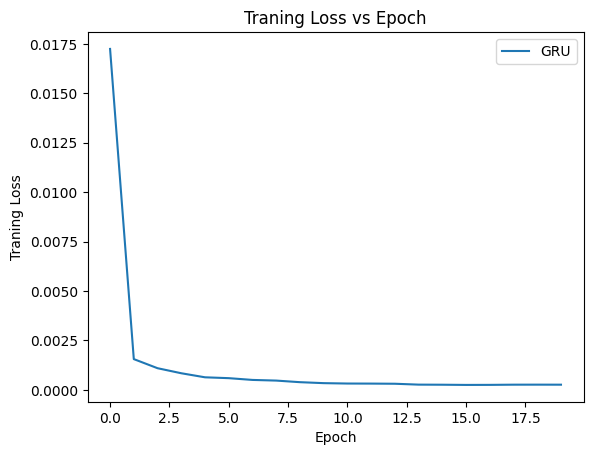

In [ ]:
plt.plot(np.arange(epoch),gru_loss,label="GRU")
plt.xlabel("Epoch")
plt.ylabel("Traning Loss")
plt.title("Traning Loss vs Epoch")
plt.legend()
plt.show()

#**5. Comparing Performance**

###5.1 Comparing Training Loss:- Plotting baseline and Training loss vs epoch plots of RNN, LSTM, GRU in one plot

#### 5.1.1 baseline calculation

BaseLine :- We will take all y_pred as 1, and then we will calculate loss between prediction and original labels.

->This is to check performnce of our Elmon RNN,GRU and LSTM compared to the model which always predicts sum of 1.

(*definition Based on the dicussion with Professor)

In [ ]:
#Baseline that always predicts a sum of 1
y_pred = torch.ones(len(X_train))
baseline_loss = criterion(y_pred,y_train)
print("Base line:",baseline_loss.item())

Base line: 0.16940365599019858


* We can observe, the loss for GRU, LSTM and RNN will always be less than BaseLine

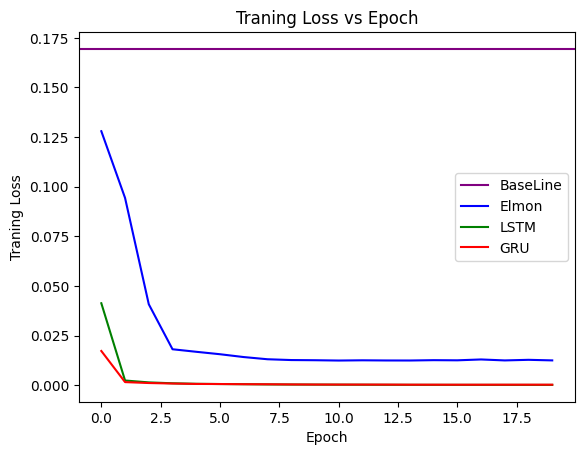

In [ ]:
plt.axhline(y=baseline_loss, color='purple', linestyle='-',label="BaseLine")
plt.plot(np.arange(epoch),elmon_loss,color='blue',label="Elmon")
plt.plot(np.arange(epoch),lstm_loss,color='green',label="LSTM")
plt.plot(np.arange(epoch),gru_loss,color='red',label="GRU")
plt.title("Traning Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Traning Loss")
plt.legend()
plt.show()

###5.2 Test Accuracy and Test Loss

* For accuracy, I am using thresholding logic as suggested by professor.
* if predicted sum value i.e y_pred and original sum values i.e y_real's absolute difference is less than 0.02 than it's will consider as current prediction.


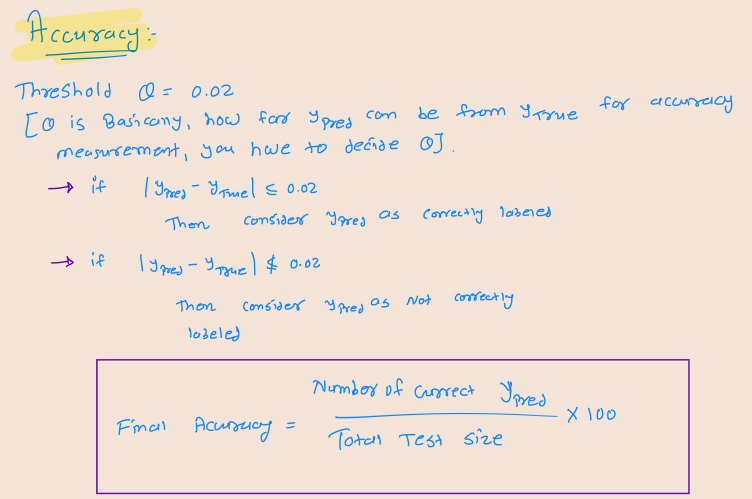

In [ ]:
#Accuracy and loss calculation for test data for RNN

def test_one_seq_elmon(test_seq):
  hidden = elmon.initHidden()
  
  #for each time stamp
  for i in range(test_seq.size()[0]):
    temp = torch.reshape(test_seq[i],(1,2))
    output,hidden = elmon(temp,hidden)

  return output

def elmon_accuracy(X_test,y_test):
  acc = []
  pred = torch.zeros((y_test.shape[0]),dtype=torch.float64)

  for i in range(y_test.shape[0]):
    y_real = y_test[i].item()
    y_pred = test_one_seq_elmon(X_test[i]).item()
    pred[i] = y_pred
    if(abs(y_real-y_pred)<=0.02):
      acc.append(1)
    else:
      acc.append(0)

  accuracy = ((sum(acc)/len(acc))*100)
  loss = criterion(pred,y_test)
  
  return accuracy,loss,pred

In [ ]:
#Accuracy and loss calculation for test data for LSTM

def test_one_seq_lstm(test_seq):
  hidden = lstm.initHidden()
  cell = lstm.initHidden()
  #for each time stamp
  for i in range(test_seq.size()[0]):
    temp = torch.reshape(test_seq[i],(1,2))
    output,hidden,cell = lstm(temp,hidden,cell)

  return output

def lstm_accuracy(X_test,y_test):
  acc = []
  pred = torch.zeros((y_test.shape[0]), dtype=torch.float64)

  for i in range(y_test.shape[0]):
    y_real = y_test[i].item()
    y_pred = test_one_seq_lstm(X_test[i]).item()
    pred[i] = y_pred
    if(abs(y_real-y_pred)<=0.02):
      acc.append(1)
    else:
      acc.append(0)

  accuracy = ((sum(acc)/len(acc))*100)
  loss = criterion(pred,y_test)
  
  return accuracy,loss,pred

In [ ]:
#Accuracy and loss calculation for test data for GRU

def test_one_seq_gru(test_seq):
  hidden = gru.initHidden()
  
  #for each time stamp
  for i in range(test_seq.size()[0]):
    temp = torch.reshape(test_seq[i],(1,2))
    output,hidden = gru(temp,hidden)

  return output

def gru_accuracy(X_test,y_test):
  acc = []
  pred = torch.zeros((y_test.shape[0]), dtype=torch.float64)

  for i in range(y_test.shape[0]):
    y_real = y_test[i].item()
    y_pred = test_one_seq_gru(X_test[i]).item()
    pred[i] = y_pred
    if(abs(y_real-y_pred)<=0.02):
      acc.append(1)
    else:
      acc.append(0)

  accuracy = ((sum(acc)/len(acc))*100)
  loss = criterion(pred,y_test)
  
  return accuracy,loss,pred

In [ ]:
print("Accuracy of Elmon RNN for Test data:",elmon_accuracy(X_test,y_test)[0])
print("Accuracy of LSTM for Test data:",lstm_accuracy(X_test,y_test)[0])
print("Accuracy of GRU for Test data:",gru_accuracy(X_test,y_test)[0])

Accuracy of Elmon RNN for Test data: 23.636363636363637
Accuracy of LSTM for Test data: 97.51515151515152
Accuracy of GRU for Test data: 99.75757575757575


In [ ]:
print("MSE loss of Elmon RNN for Test data::",elmon_accuracy(X_test,y_test)[1].item())
print("MSE loss of LSTM for Test data::",lstm_accuracy(X_test,y_test)[1].item())
print("MSE loss of GRU for Test data::",gru_accuracy(X_test,y_test)[1].item())

MSE loss of Elmon RNN for Test data:: 0.006467445879180481
MSE loss of LSTM for Test data:: 6.687525487018564e-05
MSE loss of GRU for Test data:: 2.4532436827837884e-05


### 5.3 Final conclusion

* GRU is faster than LSTM for processing the same dataset.
* And in terms of performance, GRU performance will surpass LSTM in the scenario of long text and small dataset, and inferior to LSTM in 
other scenarios.
* This we can also verify from the <a href="https://ieeexplore.ieee.org/document/9221727">IEEE paper on LSTM and GRU Neural Network Performance Comparison Study</a>

**Reference** - S. Yang, X. Yu and Y. Zhou, "LSTM and GRU Neural Network Performance Comparison Study: Taking Yelp Review Dataset as an Example," 2020 International Workshop on Electronic Communication and Artificial Intelligence (IWECAI), Shanghai, China, 2020, pp. 98-101, doi: 10.1109/IWECAI50956.2020.00027.

### 5.4 Based on Professor's comment on google classroom (on Assignment 4 post )which says 
"you may introduce some test samples  beyond 9 for evaluating the model"
* I am generating some test samples of length 25 and 27 to so case the working of trained model on length between 2 to 9

In [ ]:
torch.manual_seed(88)
np.random.seed(1)

dataset_size=3
min_seq_lenght = 25
max_seq_lenght = 28
seq_lenghts = np.arange(min_seq_lenght,max_seq_lenght,dtype=int)

X,y = create_dataset(dataset_size=dataset_size,lenghts=seq_lenghts)

100%|██████████| 3/3 [00:00<00:00, 3083.29it/s]


* I have generated dataset with 3 sequence each with size 26,27 and 25

In [ ]:
print(len(X[0]))
print(len(X[1]))
print(len(X[2]))

26
27
25


In [ ]:
#Predicting the labels
_,_,prediction1=elmon_accuracy(X,y)
_,_,prediction2=lstm_accuracy(X,y)
_,_,prediction3=gru_accuracy(X,y)

* for sequence lenght 26

In [ ]:
print("True label:",y[0].item())
print("label predicted by Elmon RNN:",prediction1[0].item())
print("label predicted by LSTM::",prediction2[0].item())
print("label predicted by GRU::",prediction3[0].item())

True label: 0.9309946362430431
label predicted by Elmon RNN: 0.6126318095707853
label predicted by LSTM:: 0.9159549090304869
label predicted by GRU:: 0.9314597440904795


* for sequence lenght 27

In [ ]:
print("True label:",y[1].item())
print("label predicted by Elmon RNN:",prediction1[1].item())
print("label predicted by LSTM::",prediction2[1].item())
print("label predicted by GRU::",prediction3[1].item())

True label: 1.1643491460944242
label predicted by Elmon RNN: 0.8180075860912905
label predicted by LSTM:: 1.1200769089972462
label predicted by GRU:: 1.128896468513822


* for sequence lenght 25

In [ ]:
print("True label:",y[2].item())
print("label predicted by Elmon RNN:",prediction1[2].item())
print("label predicted by LSTM::",prediction2[2].item())
print("label predicted by GRU::",prediction3[2].item())

True label: 1.0456709005486768
label predicted by Elmon RNN: 0.898357926119362
label predicted by LSTM:: 1.0313946922565733
label predicted by GRU:: 1.0381026506894937


* For this test cases also we can observe, labels predicted by GRU, LSTM are very close to ground truth than Elmon RNN